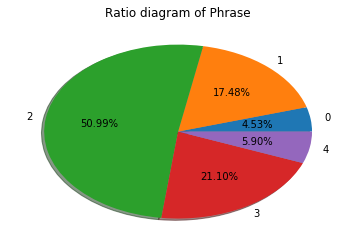

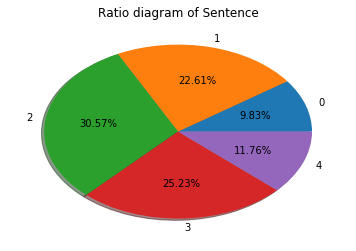

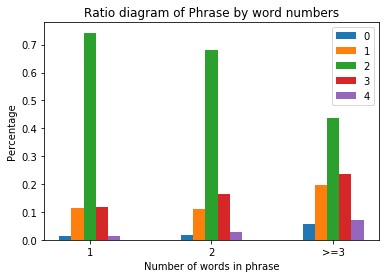

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

data = pandas.read_table("../input/movie-review-sentiment-analysis-kernels-only/train.tsv")
# display(data)
labels = ["0", "1", "2", "3", "4"]

numberPhrase = data.groupby("Sentiment").count().PhraseId
plt.pie(list(numberPhrase), labels=labels, autopct='%.2f%%', shadow=True)

plt.title('Ratio diagram of Phrase')
plt.show()

numberSentence = data.groupby("Sentiment").SentenceId.nunique()
plt.pie(list(numberSentence), labels=labels, autopct='%.2f%%', shadow=True)
plt.title('Ratio diagram of Sentence')
plt.show()

numberLengthText = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
for i in range(len(data.PhraseId)):
    phrase = data.Phrase[i]
    words = phrase.split(" ")
    numberLengthText[min(len(words)-1, 2)][int(data.Sentiment[i])] += 1

numberLengthText = numpy.array(numberLengthText, dtype=numpy.float32)
for i in range(3):
    numberLengthText[i, :] /= numpy.sum(numberLengthText[i, :])
x = ["1", "2", ">=3"]
x_ = numpy.arange(len(x))
plt.bar(x_-0.2, numberLengthText[:, 0], 0.1, label=labels[0])
plt.bar(x_-0.1, numberLengthText[:, 1], 0.1, label=labels[1])
plt.bar(x_, numberLengthText[:, 2], 0.1, label=labels[2])
plt.bar(x_+0.1, numberLengthText[:, 3], 0.1, label=labels[3])
plt.bar(x_+0.2, numberLengthText[:, 4], 0.1, label=labels[4])
plt.xticks(x_, x)
plt.legend()
plt.xlabel('Number of words in phrase')
plt.ylabel('Percentage')
plt.title('Ratio diagram of Phrase by word numbers')
plt.show()

In [3]:
import os
import word2vec
import numpy

class Preprocessor:
    @staticmethod
    def lemmatize(word):
        if word[-4:] == "sess":
            return word[:-4]+"ss"
        if word[-3:] == "ies":
            return word[:-3]+"y"
        if word[-2:] == "ss":
            return word
        if word[-1:] == "s":
            return word[:-1]
        if word == "'s":
            return "be"

    @staticmethod
    def tokenize(sentence):
        return sentence.lower().split(" ")

class W2VProcessor:
    def __init__(self, originData=None, dataFolder="", vectorSize=100):
        self.__model = None
        self.__vectorSize = vectorSize
        if type(originData) is str:
            word2vec.word2vec(
                originData, 
                os.path.join(dataFolder, "vec.w2v"), 
                size=vectorSize, 
                verbose=True)
            self.__model = word2vec.load(os.path.join(dataFolder, "vec.w2v"))

    def load(self, wordVectorFile):
        self.__model = word2vec.load(wordVectorFile)
        self.__vectorSize = self.__model.vectors.shape[1]

    def getVectorSize(self):
        return self.__vectorSize

    def process(self, sentence, length=None):
        if self.__model is None:
            print("Error: The model is None")
            return None

        if not sentence:
            print("Error: The sentence is None")
            return None
        
        sentence = Preprocessor.tokenize(sentence)

        if length is None:
            length = len(sentence)
        sentence = sentence[:length]
        tensor = []
        for word in sentence:
            try:
                tensor.append(self.__model[word])
            except:
                try:
                    tensor.append(self.__model[Preprocessor.lemmatize(word)])
                except:    
                    tensor.append(numpy.zeros((self.__vectorSize,)))
        for i in range(length-len(sentence)):
            tensor.append(numpy.zeros(tensor[0].shape))
        tensor = numpy.concatenate(tensor).reshape((length, len(tensor[0])))

        return tensor


In [4]:
import numpy
import tensorflow

class CNN:
    def __init__(self, wordVectSize=200, numOfWords=25, learningRate=0.001, numFilters=32):
        self.__numberOfWords = numOfWords
        self.__sizeOfWordVectors = wordVectSize
        self.__graph = tensorflow.Graph()
        self.__globalStep = tensorflow.Variable(0, trainable=False)
        self.__learningRate = tensorflow.train.exponential_decay(
            learningRate, self.__globalStep, decay_steps=100, decay_rate=0.98, staircase=True)
        
        self.__input = tensorflow.placeholder(tensorflow.float32, shape=[None, numOfWords, wordVectSize])
        self.__label = tensorflow.placeholder(tensorflow.float32, shape=[None])
        self.__dropout = tensorflow.placeholder(tensorflow.float32, shape=[])
        
        conv1 = tensorflow.layers.conv1d(self.__input, filters=numFilters, kernel_size=1, padding="valid")
        conv3 = tensorflow.layers.conv1d(self.__input, filters=numFilters, kernel_size=3, padding="valid")
        conv5 = tensorflow.layers.conv1d(self.__input, filters=numFilters, kernel_size=5, padding="valid")

        pool1 = tensorflow.layers.max_pooling1d(conv1, pool_size=(numOfWords, ), strides=1)
        pool3 = tensorflow.layers.max_pooling1d(conv3, pool_size=(numOfWords-2, ), strides=1)
        pool5 = tensorflow.layers.max_pooling1d(conv5, pool_size=(numOfWords-4, ), strides=1)
        
        conca = tensorflow.concat([pool1, pool3, pool5], axis=2)
        dropo = tensorflow.nn.dropout(conca, self.__dropout)
        self.__logits = tensorflow.layers.dense(dropo, units=5, activation=tensorflow.nn.softmax)
        self.__classes = tensorflow.argmax(self.__logits, axis=1)
        
        onehotLabels = tensorflow.one_hot(indices=tensorflow.cast(self.__label, tensorflow.int32), depth=5)
        onehotLabels = tensorflow.reshape(onehotLabels, [-1, 1, 5])
        self.__loss = tensorflow.losses.softmax_cross_entropy(onehot_labels=onehotLabels, logits=self.__logits)

        self.__trainOp = tensorflow.contrib.layers.optimize_loss(
            loss=self.__loss,
            global_step=self.__globalStep,
            learning_rate=self.__learningRate,
            optimizer="SGD"
        )

        self.__session = tensorflow.Session()
        self.__session.run(tensorflow.global_variables_initializer())
        self.__saver = tensorflow.train.Saver()
        
    def fit_on_batch(self, trainData, label):
        feedDict = {
            self.__input: trainData,
            self.__label: label,
            self.__dropout: 0.5
        }

        _, loss = self.__session.run([self.__trainOp, self.__loss], feed_dict=feedDict)
        return loss

    def predict(self, testData):
        return self.__session.run([self.__classes], feed_dict={self.__input: testData, self.__dropout: 1.0})[0]

In [5]:
import random
import pandas
import numpy
from sklearn.metrics import accuracy_score

sentenceSize = 25
processor = W2VProcessor()
processor.load("../input/word2vec-model/vectors.bin")
clf = CNN(numOfWords=sentenceSize)
epochNum = 200
batchSize = 50
trainRatio = 0.7

processedData = [processor.process(phrase, sentenceSize) for phrase in data.Phrase]
trainingData = processedData[:int(trainRatio*len(processedData))]
testingData = processedData[int(trainRatio*len(processedData)):]

X = numpy.array(trainingData)
Y = numpy.array(pandas.to_numeric(data.Sentiment[:int(trainRatio*len(processedData))]), dtype=numpy.float32)
x = numpy.array(testingData)
y = numpy.array(pandas.to_numeric(data.Sentiment[int(trainRatio*len(processedData)):]), dtype=numpy.float32)

losses = []
accuracies = []
for epoch in range(epochNum):
    totalLoss = 0
    indice = 0
    for i in range(0, len(trainingData), batchSize):
        totalLoss += clf.fit_on_batch(X[i:i+batchSize, :, :], Y[i:i+batchSize])
        indice += 1
    losses.append(totalLoss/indice)
    
    z = clf.predict(x)
    accuracy = accuracy_score(y, z)
    accuracies.append(accuracy)

NameError: name 'processesData' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(losses)), losses)
ax1.set_title('Training loss')
ax2.plot(range(len(accuracies)), accuracies)
ax2.set_title('Validation accuracy')
fig.subplots_adjust(hspace=0.5)
plt.show()